<a href="https://colab.research.google.com/github/athifm/neuromatch_CN/blob/main/DriftingQueens_Notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install things

In [ ]:
# Install these!
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade
# you will need to 'Restart runtime' afterward

     |████████████████████████████████| 1.6MB 3.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 73 kB 916 kB/s 
     |████████████████████████████████| 1.7 MB 12.4 MB/s 
     |████████████████████████████████| 130 kB 50.6 MB/s 
     |████████████████████████████████| 668 kB 45.0 MB/s 
     |████████████████████████████████| 47.4 MB 32 kB/s 
     |████████████████████████████████| 2.9 MB 58.8 MB/s 
     |████████████████████████████████| 3.4 MB 48.6 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 3.4 MB 39.2 MB/s 
     |████████████████████████████████| 149 kB 46.7 MB/s 
     |████████████████████████████████| 98 kB 7.1 MB/s 
     |████████████████████████████████| 1.3 MB 40.9 MB/s 
     |████████████████████████████████| 72 kB 742 kB/s 
     |████████████████████████████████| 129 kB 48.7 MB/s 
     |███████████████████████

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

# Place data in cache

In [ ]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

ophys_session_table.csv: 100%|██████████| 165k/165k [00:00<00:00, 1.24MMB/s] 
behavior_session_table.csv: 100%|██████████| 885k/885k [00:00<00:00, 6.38MMB/s] 
ophys_experiment_table.csv: 100%|██████████| 336k/336k [00:00<00:00, 2.43MMB/s] 


In [ ]:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

#Set up functions to find container IDs that repeat across sessions

In [ ]:
def unique(list1):
    # intilize a null list
    unique_list = []
    
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

def find_repeat_cont_id(mouse_sessions):
  # Function that finds the planes of imaging present across all sessions

  container_ids = mouse_sessions['ophys_container_id'].values
  cont_id_list = []

  for id in range(len(container_ids)):
    temp_ids = container_ids[id]
    for x in temp_ids:
      cont_id_list.append(x)
  unique_cont = unique(cont_id_list)
  # print(unique_cont)

  repeat_cont = []
  for i in unique_cont:
    count = cont_id_list.count(i)
    if count == mouse_sessions.shape[0]:
      repeat_cont.append(i)
  return repeat_cont

def find_mouse_cont_id(mouse_ids, sessions):
  # Returns an array with a mouse ID and container ID present in all sessions

  mouse_containers = []
  first = 0 #variable for the first container identified

  for mouse in mouse_ids:
    mouse_sessions = sessions[sessions.mouse_id == mouse]
    repeat_container_ids = find_repeat_cont_id(mouse_sessions)

    # Loop over all repeat container IDs
    for i in range(np.size(repeat_container_ids)):

      # if it is the first one, initialize mouse_containers
      if first == 0:
        mouse_containers = [mouse, repeat_container_ids[i]]
        first = 1

      # otherwise, concatenate mouse_containers
      else:
        mouse_containers = np.vstack((mouse_containers, [mouse, repeat_container_ids[i]]))
  return mouse_containers

def load_experiment_cache(container_id):
  experiments = {}

  selected_experiment_table = experiment_table[experiment_table.ophys_container_id==container]
  temp_exp_ids = selected_experiment_table['ophys_session_id'].keys()
  # temp_exp_ids.keys()
  for ophys_experiment_id in temp_exp_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)
  return temp_exp_ids, experiments

#Set up variables for different types of Cre lines

In [ ]:
# Isolate sessions with multiscope recordings
multiplane_sessions = session_table.loc[session_table.project_code == "VisualBehaviorMultiscope"]

# Separate Sst and Vip sessions
sst_sessions = multiplane_sessions.loc[multiplane_sessions.cre_line == "Sst-IRES-Cre"]
vip_sessions = multiplane_sessions.loc[multiplane_sessions.cre_line == "Vip-IRES-Cre"]
slc_sessions = multiplane_sessions.loc[multiplane_sessions.cre_line == "Slc17a7-IRES2-Cre"]

# Find the mouse_id for the Sst and Vip mice used as well as their associated sessions
mouse_id_sst = sst_sessions['mouse_id'].unique()
mouse_id_vip = vip_sessions['mouse_id'].unique()
mouse_id_slc = slc_sessions['mouse_id'].unique()

# Find the container IDs that are present across all recording sessions
containers_sst = find_mouse_cont_id(mouse_id_sst, sst_sessions)
containers_vip = find_mouse_cont_id(mouse_id_vip, vip_sessions)
containers_slc = find_mouse_cont_id(mouse_id_slc, slc_sessions)

# Specifying container ID and session index just while we set up things
Remove later and probably set up a for loop for all mice

In [ ]:
container = containers_vip[0,1]
sess_idx = 3 # this is the first novel session for this container

# Place neural data in a dataframe

In [ ]:
# load experiment data
exp_ids, experiments = load_experiment_cache(container)

neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)

    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

In [ ]:
exp_ids

Int64Index([1048483611, 1049610123, 1050485652, 1050762972, 1051249029,
            1051460016],
           dtype='int64', name='ophys_experiment_id')

In [ ]:
neural_data

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,9.24023,13.793382,0.000000,0.000000,1080637709,1086614936,1048483611,1048363441,VISl,150,MESO.1,Vip-IRES-Cre,523922,M
1,9.34972,14.778268,0.000000,0.000000,1080637709,1086614936,1048483611,1048363441,VISl,150,MESO.1,Vip-IRES-Cre,523922,M
2,9.45920,7.851378,0.000000,0.000000,1080637709,1086614936,1048483611,1048363441,VISl,150,MESO.1,Vip-IRES-Cre,523922,M
3,9.56869,14.369932,5.710562,1.899324,1080637709,1086614936,1048483611,1048363441,VISl,150,MESO.1,Vip-IRES-Cre,523922,M
4,9.67817,17.511370,5.381006,3.465862,1080637709,1086614936,1048483611,1048363441,VISl,150,MESO.1,Vip-IRES-Cre,523922,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41160,4516.99851,-1.067966,0.000000,0.000000,1080632053,1086616758,1051460016,1051319542,VISl,140,MESO.1,Vip-IRES-Cre,523922,M
41161,4517.10802,1.725232,0.000000,0.000000,1080632053,1086616758,1051460016,1051319542,VISl,140,MESO.1,Vip-IRES-Cre,523922,M
41162,4517.21753,0.980700,0.000000,0.000000,1080632053,1086616758,1051460016,1051319542,VISl,140,MESO.1,Vip-IRES-Cre,523922,M
41163,4517.32704,1.548078,0.000000,0.000000,1080632053,1086616758,1051460016,1051319542,VISl,140,MESO.1,Vip-IRES-Cre,523922,M


# Take a look at neuronal data

In [ ]:
cell_ids = neural_data['cell_specimen_id'].unique()
print('there are {} unique cells'.format(len(cell_ids)))
print('cell ids are: {}'.format(cell_ids))

there are 28 unique cells
cell ids are: [1086614936 1086617587 1086615099 1086615199 1086615304 1086618399
 1086615920 1086618850 1086616102 1086616223 1086616403 1086616628
 1086616758 1086616873 1086617003 1086617117 1086618300 1086617376
 1086618361 1086617476 1086615409 1086617255 1086617707 1086615581
 1086615670 1086615441 1086618207 1086618436]


In [ ]:
for cell in cell_ids:
  find_cell = neural_data[neural_data.cell_specimen_id==cell]
  num_exp_per_cell = len(find_cell['ophys_session_id'].unique())
  print(num_exp_per_cell)

6
2
6
5
6
1
5
1
6
6
6
5
6
6
6
3
3
5
2
6
1
4
2
1
1
1
1
1


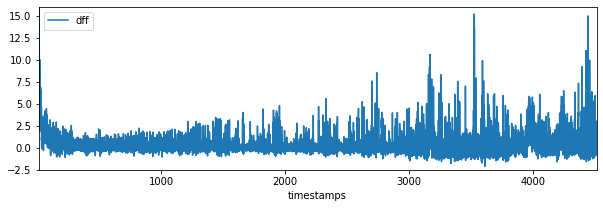

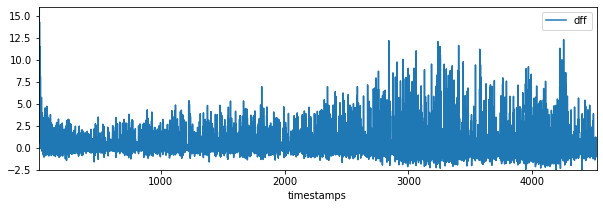

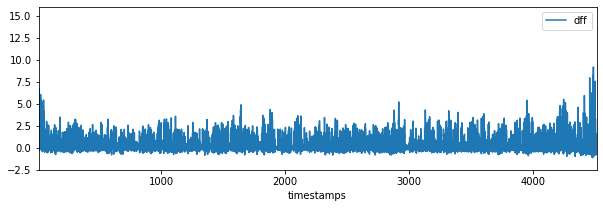

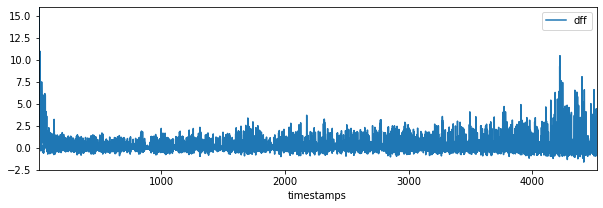

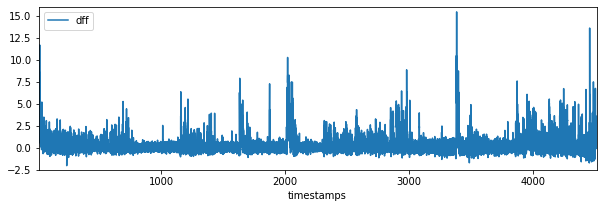

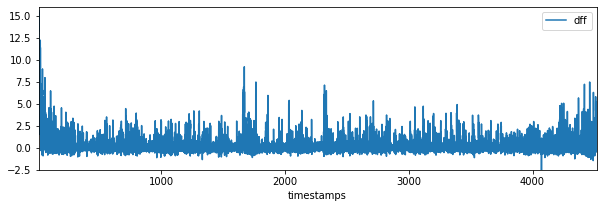

In [ ]:
find_cell = neural_data[neural_data.cell_specimen_id==cell_ids[0]]
cell_sessions = find_cell['ophys_session_id'].unique()

for sess in cell_sessions:
  single_cell_timeseries = neural_data[(neural_data.cell_specimen_id == cell_ids[0])&(neural_data.ophys_session_id == sess)]

  fig, ax = plt.subplots(figsize=(10,3))
  single_cell_timeseries.plot(
      x = 'timestamps',
      y = 'dff',
      ax = ax
  )
  plt.ylim(-2.5, 16)

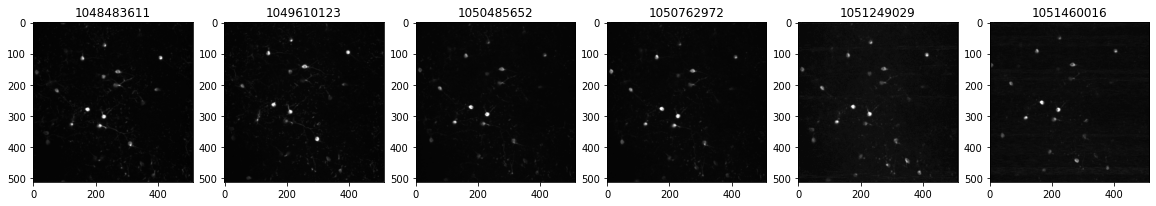

In [ ]:
# plot the max intensity projection - are they well aligned across sessions? can you identify the same neurons?

# create figure axis
fig, ax = plt.subplots(1, len(exp_ids), figsize=(20,5))
# enumerate over experiments in this container
for i, ophys_experiment_id in enumerate(exp_ids): 
    # get the dataset object
    dataset = cache.get_behavior_ophys_experiment(ophys_experiment_id=ophys_experiment_id)
    # get the max intensity projection and plot on the appropriate axis
    ax[i].imshow(dataset.max_projection.data, cmap='gray')
    ax[i].set_title(ophys_experiment_id)

In [ ]:
selected_experiment_table = experiment_table[experiment_table.ophys_container_id==container]
selected_experiment_table

,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,cre_line,indicator,session_number,prior_exposures_to_session_type,prior_exposures_to_image_set,prior_exposures_to_omissions,ophys_session_id,behavior_session_id,ophys_container_id,project_code,imaging_depth,targeted_structure,date_of_acquisition,session_type,file_id
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,,
1048483611,MESO.1,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,523922,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],M,172.0,Vip-IRES-Cre,GCaMP6f,1.0,2,47.0,2,1048363441,1048388846,1046576787,VisualBehaviorMultiscope,150,VISl,2020-09-04 08:47:06.432055,OPHYS_1_images_A,1085394264
1049610123,MESO.1,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,523922,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],M,177.0,Vip-IRES-Cre,GCaMP6f,2.0,0,48.0,3,1049240847,1049260803,1046576787,VisualBehaviorMultiscope,146,VISl,2020-09-09 10:02:49.952283,OPHYS_2_images_A_passive,1085402361
1050485652,MESO.1,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,523922,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],M,182.0,Vip-IRES-Cre,GCaMP6f,3.0,1,51.0,6,1050231786,1050253885,1046576787,VisualBehaviorMultiscope,144,VISl,2020-09-14 09:12:32.084927,OPHYS_3_images_A,1085402413
1050762972,MESO.1,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,523922,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],M,183.0,Vip-IRES-Cre,GCaMP6f,4.0,0,0.0,7,1050597678,1050620316,1046576787,VisualBehaviorMultiscope,142,VISl,2020-09-15 08:52:00.527831,OPHYS_4_images_B,1085394225
1051249029,MESO.1,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,523922,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],M,185.0,Vip-IRES-Cre,GCaMP6f,6.0,0,2.0,9,1051107431,1051129953,1046576787,VisualBehaviorMultiscope,140,VISl,2020-09-17 08:24:21.654082,OPHYS_6_images_B,1085395919
1051460016,MESO.1,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,523922,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],M,186.0,Vip-IRES-Cre,GCaMP6f,4.0,1,3.0,10,1051319542,1052162540,1046576787,VisualBehaviorMultiscope,140,VISl,2020-09-18 08:46:28.406833,OPHYS_4_images_B,1085396116


# Load stimulus data

In [ ]:
#Load stimulus data
stimulus_table = experiments[exp_ids[sess_idx]].stimulus_presentations.drop(columns = ['image_set']) # dropping the 'image_set' column to avoid confusion. Image_set column contains a unique string for set of images presented in a session.
stimulus_table.head()

,duration,end_frame,image_index,image_name,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,
0,0.25021,18001.0,0,im000,0,False,17986,309.53843,309.78864,False
1,0.25000,NaN,8,omitted,0,True,18030,310.27233,310.52233,False
2,0.25016,18091.0,0,im000,1,False,18076,311.03966,311.28982,False
3,0.25021,18136.0,0,im000,2,False,18121,311.79023,312.04044,False
4,0.25022,18181.0,0,im000,3,False,18166,312.54087,312.79109,False


In [ ]:
stimulus_table.query('is_change').head(10)

,duration,end_frame,image_index,image_name,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,
12,0.25021,18541.0,6,im031,11,False,18526,318.54575,318.79596,True
31,0.25021,19397.0,3,im073,29,False,19382,332.82412,333.07433,True
43,0.25019,19937.0,5,im054,41,False,19922,341.83152,342.08171,True
63,0.25012,20837.0,3,im073,60,False,20822,356.84387,357.09399,True
74,0.25024,21331.0,0,im000,70,False,21316,365.08382,365.33406,True
118,0.25020,23308.0,1,im106,112,False,23293,398.11085,398.36105,True
141,0.25020,24343.0,3,im073,133,False,24328,415.37496,415.62516,True
156,0.25019,25018.0,1,im106,148,False,25003,426.63413,426.88432,True
167,0.25019,25513.0,7,im035,159,False,25498,434.89088,435.14107,True


# Look at event triggered responses at neuronal level
Here, our event of interest is a stimulus change.

In [ ]:
#Align to events
cell_id = cell_ids[0]
sess = cell_sessions[sess_idx]
etr = mindscope_utilities.event_triggered_response(
    data = neural_data.query('cell_specimen_id == @cell_id and ophys_session_id == @sess'),
    t = 'timestamps',
    y = 'dff',
    event_times = stimulus_table.query('is_change')['start_time'],
    t_before=1,
    t_after=1,
    output_sampling_rate = 5,
)

peak_norm_dff = etr.dff/max(etr.dff)  #peak normalize dff
etr.insert(2,"peak_norm_dff", peak_norm_dff) #insert in etr panda dataframe

etr

,time,dff,peak_norm_dff,event_number,event_time
0,-1.0,0.218078,0.063207,0,318.54575
1,-0.8,0.025737,0.007459,0,318.54575
2,-0.6,0.271695,0.078747,0,318.54575
3,-0.4,0.479788,0.139059,0,318.54575
4,-0.2,0.142541,0.041313,0,318.54575
...,...,...,...,...,...
3163,0.2,-0.551850,-0.159945,287,3904.14248
3164,0.4,-0.370608,-0.107415,287,3904.14248
3165,0.6,0.055970,0.016222,287,3904.14248
3166,0.8,0.335627,0.097276,287,3904.14248


In [ ]:
def make_event_triggered_plot(df, x, y, event_query, ax, t_before=3, t_after=3):
    etr = mindscope_utilities.event_triggered_response(
        data = df,
        t = 'timestamps',
        y = y,
        event_times = stimulus_table.query(event_query)['start_time'],
        t_before=t_before,
        t_after=t_after,
        output_sampling_rate = 50,
    )
    sns.lineplot(
        data=etr,
        x=x,
        y=y,
        n_boot=500,
        ax=ax
    )

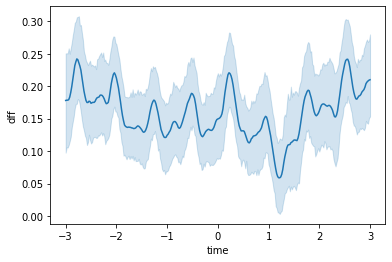

In [ ]:
cell_id = cell_ids[0]
fig, ax = plt.subplots()
make_event_triggered_plot(
    df = neural_data.query('cell_specimen_id == @cell_id and ophys_session_id == @sess'), 
    x = 'time', 
    y = 'dff', 
    event_query = 'is_change', 
    ax=ax
)

In [ ]:
#maybe should be put into a fucntion that rets dataset as an input and returns colormap etc.
# create a list of all unique stimuli presented in this experiment
unique_stimuli = [stimulus for stimulus in dataset.stimulus_presentations['image_name'].unique()]

# create a colormap with each unique image having its own color
colormap = {image_name: sns.color_palette()[image_number] for image_number, image_name in enumerate(np.sort(unique_stimuli))}
colormap['omitted'] = (1,1,1) # set omitted stimulus to white color

# add the colors for each image to the stimulus presentations table in the dataset
dataset.stimulus_presentations['color'] = dataset.stimulus_presentations['image_name'].map(lambda image_name: colormap[image_name])

In [ ]:
# function to plot dff traces
def plot_dff_trace(ax, dataset, cell_specimen_id, initial_time, final_time):
    '''
        ax: axis on which to plot
        cell_specimen_id: id of the cell to plot
        intial_time: initial time to plot from
        final_time: final time to plot to
        
    '''
  #put the code here from above because we need to update the colors as a function of the dataset structure, alternative call function once it's made
    # create a list of all unique stimuli presented in this experiment
    unique_stimuli = [stimulus for stimulus in dataset.stimulus_presentations['image_name'].unique()]

  # create a colormap with each unique image having its own color
    colormap = {image_name: sns.color_palette()[image_number] for image_number, image_name in enumerate(np.sort(unique_stimuli))}
    colormap['omitted'] = (1,1,1) # set omitted stimulus to white color

  # add the colors for each image to the stimulus presentations table in the dataset
    dataset.stimulus_presentations['color'] = dataset.stimulus_presentations['image_name'].map(lambda image_name: colormap[image_name])

    #create a dataframe using dff trace from one seleted cell
    data = {'dff': dataset.dff_traces.loc[cell_specimen_id].dff,
        'timestamps': dataset.ophys_timestamps}
    df = pd.DataFrame(data)
    dff_trace_sample = df.query('timestamps >= @initial_time and timestamps <= @final_time')
    ax.plot(
        dff_trace_sample['timestamps'],
        dff_trace_sample['dff']/dff_trace_sample['dff'].max()
    )
    
# function to plot events traces    
def plot_events_trace(ax, dataset,cell_specimen_id, initial_time, final_time):
    # create a dataframe using events trace from one seleted cell
    data = {'events': dataset.events.loc[cell_specimen_id].events,
        'timestamps': dataset.ophys_timestamps}
    df = pd.DataFrame(data)
    events_trace_sample = df.query('timestamps >= @initial_time and timestamps <= @final_time')
    ax.plot(
        events_trace_sample['timestamps'],
        events_trace_sample['events']/events_trace_sample['events'].max() #peak normalize the dff data according to max dff
    )
  
def plot_stimuli(ax, dataset, initial_time, final_time):
    stimulus_presentations_sample = dataset.stimulus_presentations.query('stop_time >= @initial_time and start_time <= @final_time')
    for idx, stimulus in stimulus_presentations_sample.iterrows():
        ax.axvspan(stimulus['start_time'], stimulus['stop_time'], color=stimulus['color'], alpha=0.25)

**Plot dff over time as a function of stimuli - for a single neuron across sessions**

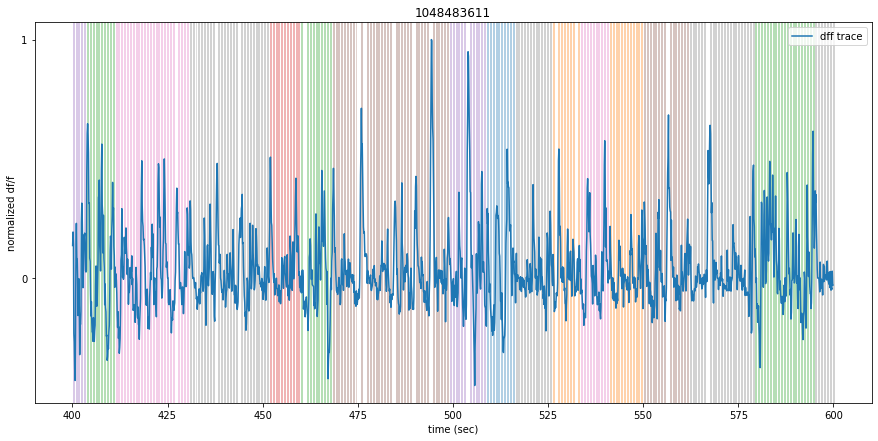

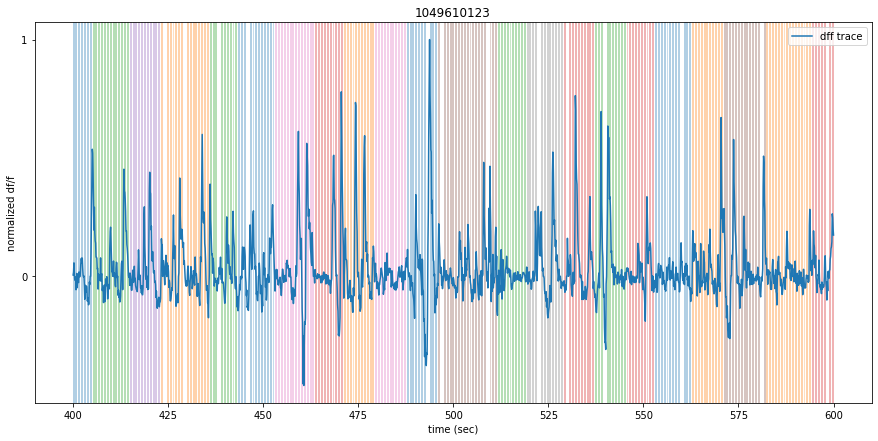

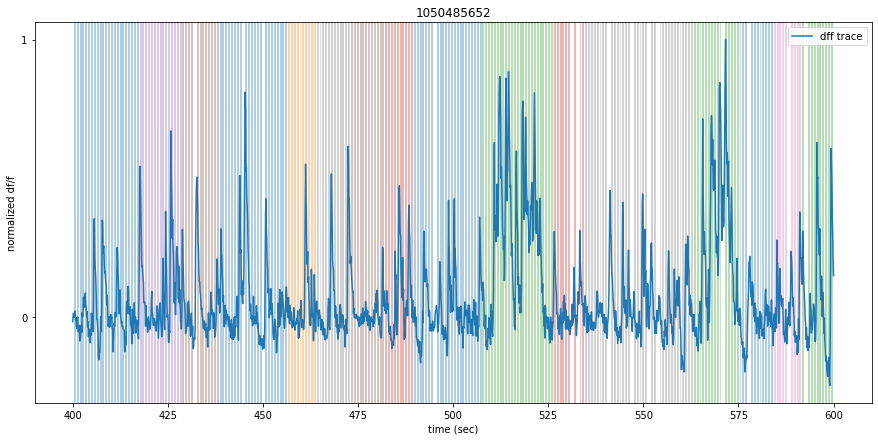

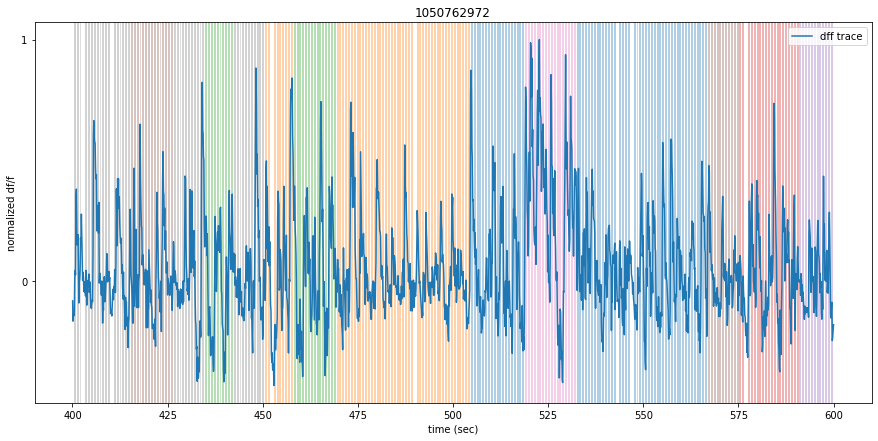

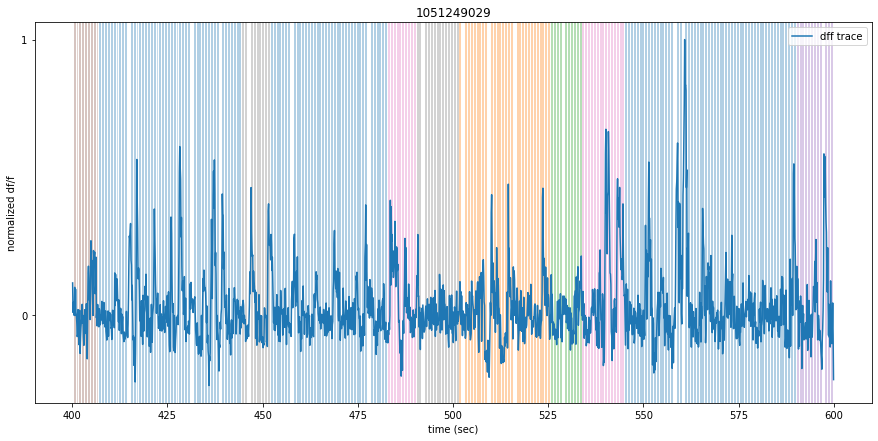

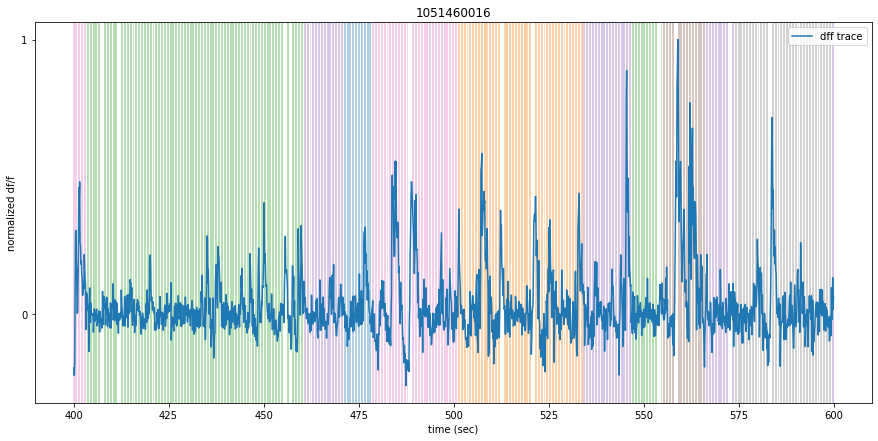

In [ ]:
initial_time = 400 # start time in seconds - just some test values
final_time = 600 # stop time in seconds - just some test values

for i, ophys_experiment_id in enumerate(exp_ids): 
    # get the dataset object
  dataset = cache.get_behavior_ophys_experiment(ophys_experiment_id=ophys_experiment_id)
  cell_id = cell_ids[0]

  fig, ax = plt.subplots(1,1,figsize = (15,7)) # just 1 neurons for now

  plot_dff_trace(ax, dataset, cell_id, initial_time, final_time)
  plot_stimuli(ax, dataset, initial_time, final_time)
  ax.set_xlabel('time (sec)')
  ax.set_ylabel('normalized df/f')
  ax.set_yticks([0,1])
  ax.legend(['dff trace'])
  ax.set_title(ophys_experiment_id)

ValueError: ignored

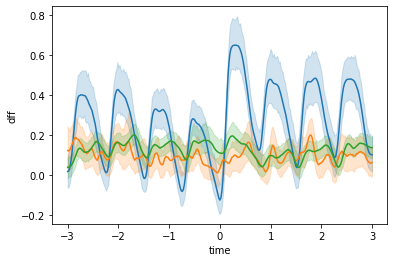

In [ ]:
#Need to fix and continue - not all cells are in all sessions, need to make new cell_ids variable
np.random.seed(0)
fig, ax = plt.subplots()
for cell_id in tqdm(np.random.choice(cell_ids, size=10, replace=False)):
    
    make_event_triggered_plot(
        df = neural_data.query('cell_specimen_id == @cell_id and ophys_session_id == @sess'), 
        x = 'time', 
        y = 'dff', 
        event_query = 'is_change', 
        ax=ax
    )

# What do we want to do next?
Completed:
- Fix this mindscope utilities. triggered event response function*
- Align each stim change with the dff
- Normalise dff of each cell to itself (dff / mean dff)

Next:
- Extract the normalized dff for each cell (either entire trace or certain points)
- Population level dff changes with each stim change 
- 

# Run this %pdb to debug. Run again to turn off.

In [ ]:
%pdb